In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import PolynomialDecay

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForMaskedLM

In [12]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
# Load a subset of the 'amazon_polarity'
amazon_train = load_dataset('amazon_polarity', split='train[:20000]')
amazon_test = load_dataset('amazon_polarity', split='test[:2000]')

print("Train Dataset : ", amazon_train.shape)
print("Test Dataset : ", amazon_test.shape)

Train Dataset :  (20000, 3)
Test Dataset :  (2000, 3)


In [14]:

amazon_train

Dataset({
    features: ['label', 'title', 'content'],
    num_rows: 20000
})

In [15]:
amazon_test

Dataset({
    features: ['label', 'title', 'content'],
    num_rows: 2000
})

In [16]:
print(amazon_train[0])

{'label': 1, 'title': 'Stuning even for the non-gamer', 'content': 'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'}


In [17]:
amazon_train['content'][0:5]

['This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^',
 "I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.",
 'This soundtrack is my favorite music of all time, hands down. The intense sadness of "Prisoners of Fate" (which means all th

In [18]:
# Define preprocessing variables
vocab_size = 25500
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_token = ''
embedding_dim = 25

In [19]:

df = pd.DataFrame({'Text': amazon_train['content'], 'Label': amazon_train['label']})
df.head()

,Text,Label
0,This sound track was beautiful! It paints the ...,1
1,I'm reading a lot of reviews saying that this ...,1
2,This soundtrack is my favorite music of all ti...,1
3,I truly like this soundtrack and I enjoy video...,1
4,"If you've played the game, you know how divine...",1


In [20]:
df.loc[df['Label'] == 0]

,Text,Label
6,"This is a self-published book, and if you want...",0
10,A complete waste of time. Typographical errors...,0
13,I guess you have to be a romance novel lover f...,0
14,I feel I have to write to keep others from was...,0
15,It's glaringly obvious that all of the glowing...,0
...,...,...
19995,I have previously bought three other books in ...,0
19996,"If you are like me, and thought the anthologie...",0
19997,I love the 1632 series. I have bought every bo...,0
19998,I have to say that after becoming immersed in ...,0


In [21]:
# Define preprocessing function
def preprocess_text(text):
    # Normalize and remove special character
    text = text.lower()
    text = re.sub('[^0-9a-zA-Z]', ' ', text)
    # Tokenize text
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join words back into a sentence
    text = ' '.join(words)
    return text

df['Text'] = df['Text'].apply(preprocess_text)

In [22]:
df['Text'][0]

'sound track beautiful paint senery mind well would recomend even people hate vid game music played game chrono cross game ever played best music back away crude keyboarding take fresher step grate guitar soulful orchestra would impress anyone care listen'

# Data Visualization

In [23]:
# Extract text and labels
texts = df['Text'].tolist()
labels = df['Label'].tolist()

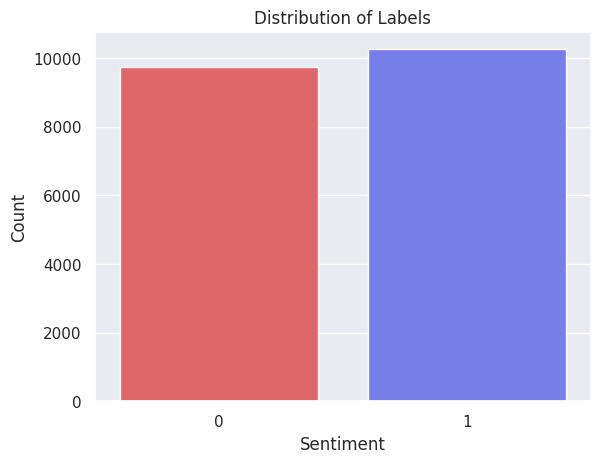

In [24]:
# Display distribution of labels
sns.set(style="darkgrid")
# Updated palette dictionary with keys as strings instead of integers
palette = {'1': '#636efa', '0': '#f45353'}  # Define colors for each sentiment

sns.countplot(data=df, x='Label', palette=palette)
plt.title('Distribution of Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [25]:
# Display example reviews
print("Example Negative Review:")
print(df[df['Label'] == 0]['Text'].iloc[57])
print("\nExample Positive Review:")
print(df[df['Label'] == 1]['Text'].iloc[23])

Example Negative Review:
yet another example superb book done serious disservice e book publisher multiple spelling error improperly placed figure caption whole section book written cap reason looking excellent reference traditional timber framing look please pick print version instead e book

Example Positive Review:
book worth keep collection advise sourdough ruth also told picture past 100 year ago alaska stand mixer civilized stuff kitchen pot sourdough


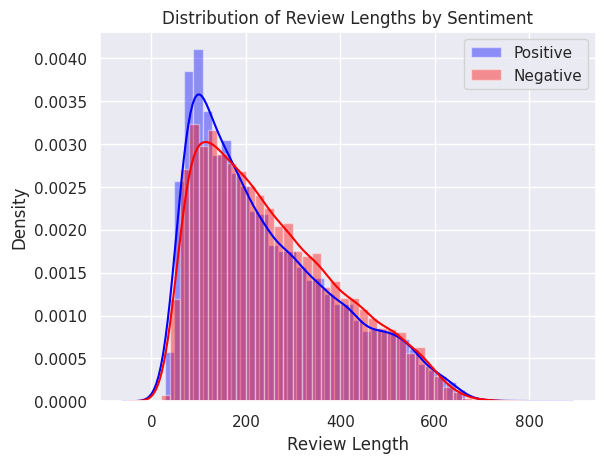

In [26]:
# Calculate the lengths of the reviews
positive_lengths = [len(text) for text, label in zip(texts, labels) if label == 1]
negative_lengths = [len(text) for text, label in zip(texts, labels) if label == 0]

# Create distplot
sns.distplot(positive_lengths, label='Positive', color='blue')
sns.distplot(negative_lengths, label='Negative',color='red')

plt.xlabel('Review Length')
plt.ylabel('Density')
plt.title('Distribution of Review Lengths by Sentiment')
plt.legend()

plt.show()

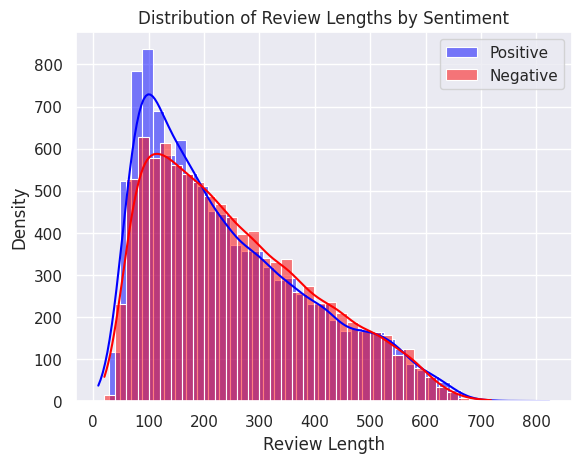

In [27]:
# Calculate the lengths of the reviews
positive_lengths = [len(text) for text, label in zip(texts, labels) if label == 1]
negative_lengths = [len(text) for text, label in zip(texts, labels) if label == 0]

# Create distplot
sns.histplot(positive_lengths, label='Positive', color='blue', kde=True)
sns.histplot(negative_lengths, label='Negative',color='red', kde=True)

plt.xlabel('Review Length')
plt.ylabel('Density')
plt.title('Distribution of Review Lengths by Sentiment')
plt.legend()

plt.show()

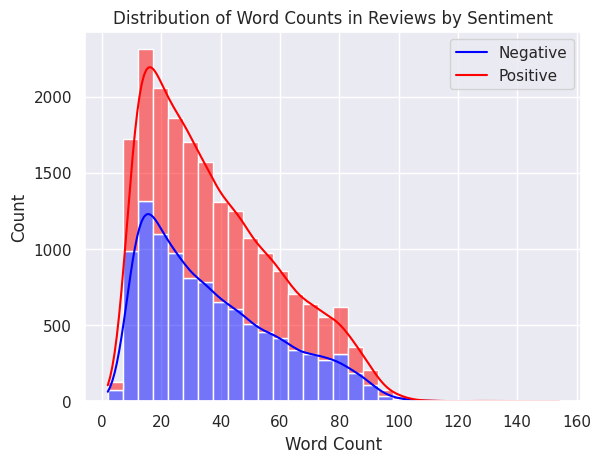

In [28]:

# Explore word count distribution in reviews
df['Word Count'] = df['Text'].apply(lambda x: len(x.split()))
sns.histplot(data=df, x='Word Count', hue='Label', bins=30, multiple='stack', kde=True, palette={0: 'red', 1: 'blue'})
plt.title('Distribution of Word Counts in Reviews by Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.legend(['Negative', 'Positive'])
plt.show()

In [29]:

df.head()

,Text,Label,Word Count
0,sound track beautiful paint senery mind well w...,1,40
1,reading lot review saying best game soundtrack...,1,42
2,soundtrack favorite music time hand intense sa...,1,68
3,truly like soundtrack enjoy video game music p...,1,73
4,played game know divine music every single son...,1,41


# Load BERT Model

In [30]:
# Initialize BERT tokenizer and model
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer, DataCollatorWithPadding

# Initialize BERT tokenizer and model
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = TFDistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [31]:
model.config

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.51.3",
  "vocab_size": 30522
}

In [32]:
# Preprocess the data
def preprocess_data(data):
    inputs = tokenizer(data['content'], truncation=True)
    return inputs

In [33]:
# Tokenize text
tokenized_datasets = amazon_train.map(preprocess_data, batched=True)
tokenized_test_datasets = amazon_test.map(preprocess_data, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

# Create datasets
tf_train_dataset = tokenized_datasets.to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'label'],
    label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)


tf_validation_dataset = tokenized_test_datasets.to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'label'],
    label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [38]:

# Create learning rate scheduler
from tensorflow.keras.optimizers.schedules import PolynomialDecay

batch_size = 8
num_epochs = 3
num_train_steps = len(tf_train_dataset) * num_epochs

lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=lr_scheduler)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [37]:
import tensorflow as tf

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',  # Pass 'adam' as a string
              metrics=['accuracy'])

model.fit(tf_train_dataset,
        validation_data=tf_validation_dataset,
        epochs=2)

Epoch 1/2
   2/2500 [..............................] - ETA: 5:15:32 - loss: 0.7341 - accuracy: 0.3750 

KeyboardInterrupt: 

In [36]:
preds = model.predict(tf_validation_dataset)["logits"]
class_preds = np.argmax(preds, axis=1)
print(preds.shape, class_preds.shape)

 11/250 [>.............................] - ETA: 17:08

KeyboardInterrupt: 

In [ ]:

import numpy as np

# Make prediction
class_preds = np.argmax(model.predict(tf_validation_dataset)["logits"], axis=1)

# Retrieve the original sentences
original_sentences = amazon_test["content"]

# Create lists to store positive and negative sentences
positive_sentences = []
negative_sentences = []

for i, pred in enumerate(class_preds):
    if pred == 1:
        positive_sentences.append(original_sentences[i])
    else:
        negative_sentences.append(original_sentences[i])

# Print some examples
print("Positive Sentences:")
for i in range(5):  # Print first 5 positive sentences
    print(positive_sentences[i])
    print("\n")


In [ ]:
# Create lists to store positive and negative sentences
positive_sentences = [amazon_test['content'][i] for i, pred in enumerate(class_preds) if pred == 1]
negative_sentences = [amazon_test['content'][i] for i, pred in enumerate(class_preds) if pred == 0]

In [ ]:
# Print some examples
print("Positive Reviews:")
for i in range(5):  # Print first 5 positive sentences
    print(positive_sentences[i])
    print("\n")

In [ ]:
# Print some examples
print("Negative Reviews:")
for i in range(5):  # Print first 5 positive sentences
    print(negative_sentences[i])
    print("\n")

In [ ]:


def predict_sentiment(input_text):
    # Preprocess input text
    inputs = tokenizer(input_text, truncation=True, padding=True, return_tensors='tf')

    # Get model prediction
    logits = model(inputs)["logits"]
    predicted_class = np.argmax(logits, axis=1)[0]

    # Determine sentiment label
    sentiment_label = "positive" if predicted_class == 1 else "negative"

    return sentiment_label

# Example usage
input_text = "This is a horrible product it sucks"
predicted_sentiment = predict_sentiment(input_text)
print(f"The sentiment is {predicted_sentiment}")l

In [ ]:
# Postive test sample
input_text = "This product is a game-changer! It's well-designed, efficient, and has greatly simplified my tasks. I couldn't be happier with my purchase!"
predicted_sentiment = predict_sentiment(input_text)
print(f"The sentiment is {predicted_sentiment}")

In [ ]:
# Negative test sample
input_text = "I'm very disappointed with this product. It constantly malfunctions and doesn't live up to its advertised capabilities. I regret buying it."
predicted_sentiment = predict_sentiment(input_text)
print(f"The sentiment is {predicted_sentiment}")